<a href="https://colab.research.google.com/github/linmyint-lab/geodata/blob/main/TECmapUsingGeo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Studying Vertical Total Electron Content (TEC) Map**

This program generates a one-day Vertical Total Electron Content (TEC) map using data from Coordinated Data Analysis Web (CDAWeb) available at https://cdaweb.gsfc.nasa.gov/.

Please note that this program is intended for academic purposes only. It was developed by Lin Myint (linminmin.my@kmitl.ac.th) and team members of THAI GNSS and SPACE WEATHER - KMITL.

In [ ]:
%matplotlib inline
import sys, time, os, subprocess
try:
  import pycdfpp
  print("pycdfpp Module is installed.")
except ImportError:
  print("pycdfpp Module is not installed os installing")
  subprocess.check_call([sys.executable, "-m", "pip", "install", 'pycdfpp'])
finally:
  import pycdfpp
import numpy as np
import requests
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import geopandas as gpd
import pandas as pd
import matplotlib.animation as animation
from IPython.display import HTML
from shapely.geometry import Point, box
import matplotlib.dates as mdates
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}

pycdfpp Module is installed.


In [ ]:
# @title Enter a date of interest
date_study = "2023-09-04" # @param {type:"date"}
date_study = pd.Timestamp(date_study);
# creating a cdf file name from  CDAWeb
cdf_file = "gps_tec15min_igs_"+date_study.strftime("%Y%m%d")+"_v01.cdf"


Reading TEC data from NASA Coordinated Data Analysis Web (CDAWeb)

In [ ]:
if os.path.isfile(cdf_file): # if data cdf file has been downloaded before
  cdf_data = pycdfpp.load(cdf_file) # reading cdf file
  print("That cdf file exist")
else:# if not, the data file will be downloaded
  url_cdaweb = "https://cdaweb.gsfc.nasa.gov/pub/data/gps/tec15min_igs/"
  url_cdf =os.path.join(url_cdaweb,str(date_study.year),cdf_file )
  query_parameters = {"downloadformat": "cdf"}
  try:
      response = requests.get(url_cdf, params=query_parameters)
      if response.status_code == 200:
          with open(cdf_file, "wb") as f:
              f.write(response.content)
      else:
          print("Failed to download the file:", response.status_code)
  except requests.ConnectionError as e:
      # Handle the connection error
      print("Connection Error:", e)
      print("The program will now exit.")
      sys.exit(1)  # Exit with a non-zero status code to indicate an error
  cdf_data = pycdfpp.load(cdf_file)# reading cdf file

That cdf file exist


In [ ]:
## for testing if CDAWeb link is not available
# query_parameters = {"downloadformat": "cdf"}
# cdf_url = 'https://drive.google.com/file/d/12wjjil4PonYMdZlKlGGG1xe_b-WegMwu/view?usp=sharing'
# cdf_path = 'https://drive.google.com/uc?export=download&id='+cdf_url.split('/')[-2]
# # cdf_data = pycdfpp.load(cdf_path)
# response = requests.get(cdf_path, headers=headers)
# if response.status_code == 200:
#   # Save the file or process the response
#   with open('gps_tec15min_igs_20240204_v01.cdf', "wb") as f:
#     f.write(response.content)
# else:
#   print("Failed to download the file:", response.status_code)
# cdf_data = pycdfpp.load('gps_tec15min_igs_20240204_v01.cdf')
# date_study = pd.Timestamp('2024/02/04');

Reading World map dataset from https://www.naturalearthdata.com/
and Dip Equator line dataset from a private Google drive

In [ ]:
zip_file = "ne_110m_admin_0_countries.zip" # world map data zip file
if os.path.isfile(zip_file): #if the zip file has been downloaded before
  world = gpd.read_file(zip_file)
  print("The world map file is exist")
else: # if not, the file is downloading
  print("The world map file is downloading")
  zip_file_url ='https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip'
  query_parameters = {"downloadformat": "zip"}
  try:
    response = requests.get(zip_file_url, headers=headers)
    if response.status_code == 200:
      # Save the file or process the response
      with open(zip_file, "wb") as f:
        f.write(response.content)
    else:
      print("Failed to download the file:", response.status_code)
  except requests.ConnectionError as e:
    # Handle the connection error
    print("Connection Error:", e)
    print("The program will now exit.")
    sys.exit(1)  # Exit with a non-zero status code to indicate an error
world = gpd.read_file(zip_file) # reading world map dataset as geodataframe

# reading dip equator line coordinates as pandas dataframe and geodataframe
# eq_url = 'https://drive.google.com/file/d/1PA2XUlFLkUj-qYznmd3j7vOvEq73ufSr/view?usp=sharing'
# eq_path = 'https://drive.google.com/uc?export=download&id='+eq_url.split('/')[-2]
eq_path = "https://raw.githubusercontent.com/linmyint-lab/geodata/1688cd5d607ed2aea13edaf8aede81f7682903af/dipEquatorLine.csv"
df_eq = pd.read_csv(eq_path,header=None,names=['lon','lat'])
gdf_eq = gpd.GeoSeries(gpd.points_from_xy(df_eq['lon'], df_eq['lat']),crs = "EPSG:4326") # reading world map dataset as geodataframe
del df_eq

The world map file is exist


Checking information of cdf file

In [ ]:
# cdf_data

Reading data as as geodataframe

In [ ]:
Epoch = pycdfpp.to_datetime64(cdf_data['Epoch'])
pd_Epoch = pd.to_datetime(Epoch)
lat = cdf_data['lat'].values.flatten()
lon = cdf_data['lon'].values.flatten()
num_stat = cdf_data['UQRnumStations'].values
num_sat = cdf_data['UQRnumSatellites'].values
tecUQR = cdf_data['tecUQR'].values
x, y = np.meshgrid(lon,lat)
iterables = [['TEC'],pd_Epoch.strftime('%b %d %Y %H:%M:%S')]
# col_list = pd.MultiIndex.from_product(iterables, names=["TEC", "Epoch"])
# data_df = pd.DataFrame(columns =col_list)
data_df = pd.DataFrame()
for i in range(pd_Epoch.shape[0]):
    #data_df['TEC',pd_Epoch[i].strftime('%b %d %Y %H:%M:%S')] = tecUQR[i].flatten()
    data_df[pd_Epoch[i].strftime('%b %d %Y %H:%M:%S')] = tecUQR[i].flatten()
data_df['lon']= x.flatten();
data_df['lat']= y.flatten();
# Create a GeoDataFrame by specifying the DataFrame and geometry column
data_gdf = gpd.GeoDataFrame(data_df, geometry=gpd.points_from_xy(data_df['lon'], data_df['lat']),crs = "EPSG:4326")
del data_df

Generating VTEC Global Map

In [ ]:
my_cmap = plt.get_cmap('coolwarm',)
fig, ax = plt.subplots(figsize=(10.0, 6.0));
world.plot(ax = ax, color='lightgrey', edgecolor='black')
data_gdf.plot(column = data_gdf.columns[0], ax = ax, cmap = my_cmap, vmin=0, vmax=100, alpha = 0.6, markersize=35,
              legend= True, legend_kwds = {"label":"TEC (TECu)", "orientation": "horizontal"} )
gdf_eq.plot(ax = ax, markersize=1, edgecolor='black')
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[0].strftime('%b %d %Y %H:%M:%S'))
plt.close()
def animate_plot(i):
  ax.clear()
  world.plot(ax = ax, color='lightgrey', edgecolor='black')
  data_gdf.plot(column = data_gdf.columns[i], ax = ax, cmap = my_cmap, vmin=0, vmax=100, alpha = 0.6, markersize=35)
  gdf_eq.plot(ax = ax, markersize=1, edgecolor='black')
  ax.set_xlim(x.min(),x.max())
  ax.set_ylim(y.min(),y.max())
  ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[i].strftime('%b %d %Y %H:%M:%S'))
  return fig
anim = animation.FuncAnimation(fig,animate_plot,len(pd_Epoch),interval=100, repeat=False)
HTML(anim.to_html5_video())

<Figure size 640x480 with 0 Axes>

Generating VTEC Global Map near magnetic equator

In [ ]:
polygon = box(-180, -30, 180, 30)
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs = "EPSG:4326")
world_clipped = world.clip(polygon)
my_cmap = plt.get_cmap('coolwarm')
fig, ax = plt.subplots(figsize=(12,5));
world.clip(polygon).plot(ax = ax, color='lightgrey', edgecolor='black')
poly_gdf.clip(polygon).boundary.plot(ax=ax, color="red")
data_gdf.clip(polygon).plot(column = data_gdf.columns[0], ax = ax, cmap = my_cmap, vmin=0, vmax=100,
                            alpha = 0.6, markersize=50, legend= True,
                            legend_kwds = {"label":"TEC (TECu)", "orientation": "horizontal"})
gdf_eq.clip(polygon).plot(ax = ax, markersize=1, edgecolor='black')
ax.set_xlim(polygon.bounds[0],polygon.bounds[2])
ax.set_ylim(polygon.bounds[1],polygon.bounds[3])
ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[0].strftime('%b %d %Y %H:%M:%S'))
#plt.gca().set_aspect(4)
plt.close()
def animate_plot(i):
    ax.clear()
    world.clip(polygon).plot(ax = ax, color='lightgrey', edgecolor='black')
    data_gdf.clip(polygon).plot(column = data_gdf.columns[i], ax = ax, cmap = my_cmap,
                                vmin=0, vmax=100, alpha = 0.6, markersize=100)
    gdf_eq.clip(polygon).plot(ax = ax, markersize=1, edgecolor='black')
    ax.set_xlim(polygon.bounds[0],polygon.bounds[2])
    ax.set_ylim(polygon.bounds[1],polygon.bounds[3])
    ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[i].strftime('%b %d %Y %H:%M:%S'))
    return fig
anim = animation.FuncAnimation(fig,animate_plot,len(pd_Epoch),interval=300, repeat=False)
HTML(anim.to_html5_video())


<Figure size 640x480 with 0 Axes>

# Ploting for each country

In [ ]:
# list of countries
list_c=world['SOVEREIGNT'].values.copy()
list_c.sort()
print(list_c)

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antarctica' 'Argentina'
 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 'Democratic Republic of the Congo' 'Denmark' 'Denmark' 'Djibouti'
 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland'
 'France' 'France' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel'
 'Israel' 'Italy' 'Ivory Coast' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kosovo' 'Kuwait' 'Kyrgyzstan' 'Laos' 'Latvia' 'Lebanon'
 'Lesotho' 'Liberi

In [ ]:
country_map= world[world['SOVEREIGNT']=='Thailand']
c_b = country_map.total_bounds
my_cmap = plt.get_cmap('coolwarm')
fig, ax = plt.subplots(figsize=(12,6));
country_map.plot(ax = ax, color='lightgrey', edgecolor='black')
data_gdf.clip(box(c_b[0],c_b[1],c_b[2],c_b[3])).plot(column = data_gdf.columns[0], ax = ax, cmap = my_cmap,
                            vmin=0, vmax=100, alpha = 0.8, markersize=1500, legend= True,
                            legend_kwds = {"label":"TEC (TECu)", "orientation": "horizontal"})
ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[0].strftime('%b %d %Y %H:%M:%S'))
ax.set_xlim(c_b[0],c_b[2])
ax.set_ylim(c_b[1],c_b[3])
plt.close()
def animate_plot(i):
    ax.clear()
    country_map.plot(ax = ax, color='lightgrey',edgecolor='black')
    data_gdf.clip(box(c_b[0],c_b[1],c_b[2],c_b[3])).plot(column = data_gdf.columns[i], ax = ax, cmap = my_cmap,
                                 vmin=0, vmax=100,alpha = 0.8, markersize=1500)
    ax.set_xlim(c_b[0],c_b[2])
    ax.set_ylim(c_b[1],c_b[3])
    ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[i].strftime('%b %d %Y %H:%M:%S'))
    return fig
anim = animation.FuncAnimation(fig,animate_plot,len(pd_Epoch),interval=300, repeat=False)
HTML(anim.to_html5_video())

<Figure size 640x480 with 0 Axes>

# Plotting diurnal vTEC data of each coordinate location

In [ ]:
r = country_map.total_bounds
cor_list = data_gdf.clip(country_map).get_coordinates(ignore_index=True)
cor_list.sort_values(by=['x','y'],inplace=True)
cor_list.reset_index(inplace=True, drop = True)
cor_list

,x,y
0,100.0,7.5
1,100.0,12.5
2,100.0,15.0
3,100.0,17.5
4,100.0,20.0
5,105.0,15.0


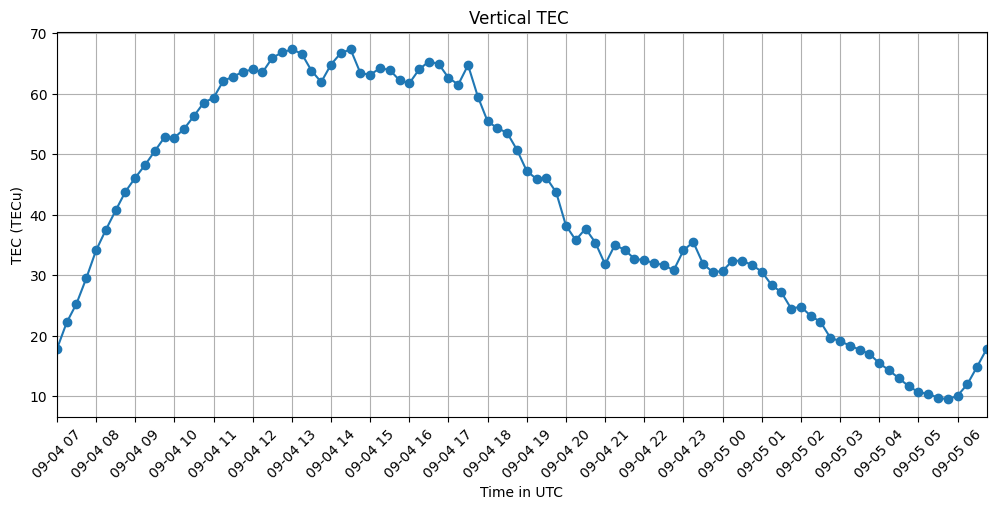

In [ ]:
# @title Choose one index number of coordinates in the list above
idx = 0 # @param {type:"integer"}

time_idx=pycdfpp.to_datetime64(cdf_data["Epoch"]) + pd.Timedelta(7,"h")
fig,ax =plt.subplots( figsize=(12,5))
lon_index =np.where(lon==cor_list['x'][idx])[0]
lat_index =np.where(lat==cor_list['y'][idx])[0]
ax.plot(time_idx, cdf_data["tecUQR"].values[:,lat_index,lon_index], marker = 'o')
ax.set_xlim(time_idx.min(),time_idx.max())
ax.grid()
ax.set( xlabel='Time in UTC', ylabel='TEC (TECu)', title= 'Vertical TEC ')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set grid line interval to 1 hour

plt.show()


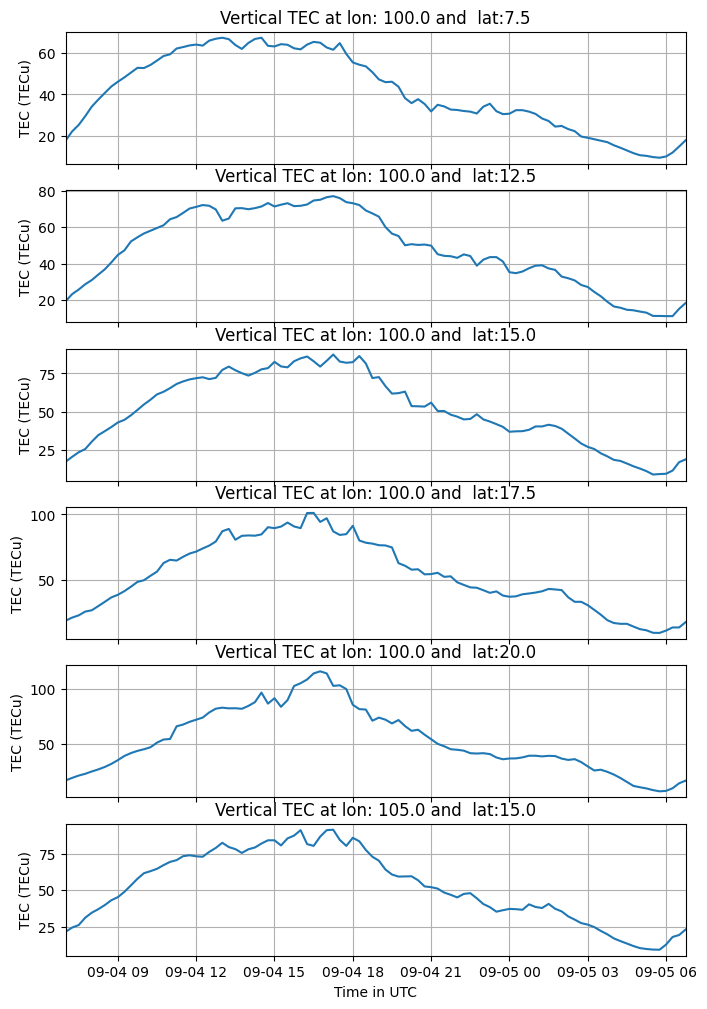

In [ ]:
# plotting for all coordinates
time_idx=pycdfpp.to_datetime64(cdf_data["Epoch"]) + pd.Timedelta(7,"h")
try:
  fig,ax =plt.subplots(nrows =len(cor_list), ncols =1, figsize=(8,12), sharex=True)
  for ind in range(len(cor_list)):
    lon_index =np.where(lon==cor_list['x'][ind])[0]
    lat_index =np.where(lat==cor_list['y'][ind])[0]
    ax[ind].plot(time_idx, cdf_data["tecUQR"].values[:,lat_index,lon_index])
    ax[ind].set( ylabel='TEC (TECu)', title= 'Vertical TEC at lon: ' +  str(lon[lon_index][0]) + ' and  lat:' + str(lat[lat_index][0]))
    ax[ind].set_xlim(time_idx.min(),time_idx.max())
    ax[ind].grid()
  ax[ind].set( xlabel='Time in UTC', ylabel='TEC (TECu)', title= 'Vertical TEC at lon: ' +  str(lon[lon_index][0]) + ' and  lat:' + str(lat[lat_index][0]))
  plt.show()
except:
  print("Error")
  plt.close()
# xlabel='Time in UTC',

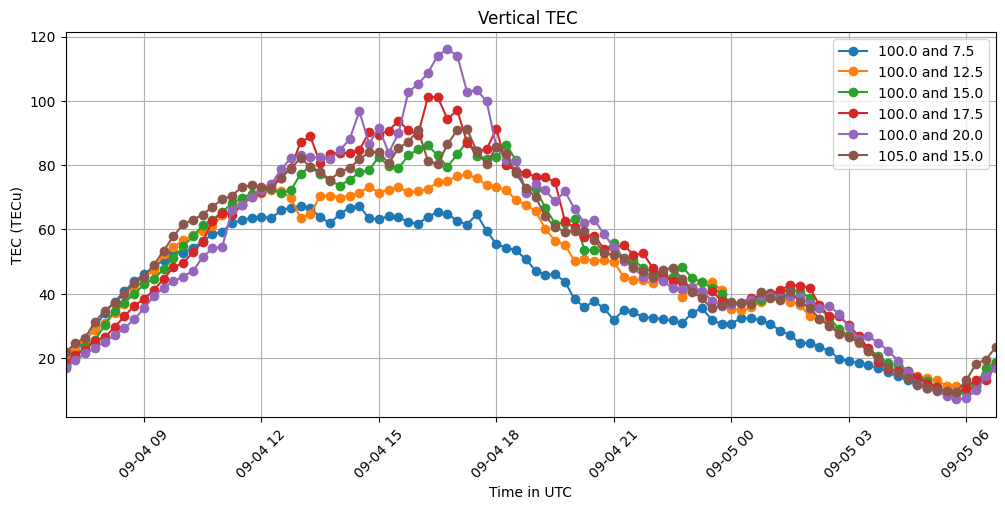

In [ ]:
time_idx=pycdfpp.to_datetime64(cdf_data["Epoch"]) + pd.Timedelta(7,"h")
fig,ax =plt.subplots( figsize=(12,5))
label = []
time_idx= pd.to_datetime(time_idx)
# for i in range(time_idx)
for ind in range(len(cor_list)):
  lon_index =np.where(lon==cor_list['x'][ind])[0]
  lat_index =np.where(lat==cor_list['y'][ind])[0]
  ax.plot(time_idx, cdf_data["tecUQR"].values[:,lat_index,lon_index], marker = 'o')
  label.append(str(lon[lon_index][0]) + ' and ' + str(lat[lat_index][0]))

ax.set_xlim(time_idx.min(),time_idx.max())
ax.grid()
ax.set( xlabel='Time in UTC', ylabel='TEC (TECu)', title= 'Vertical TEC ')
ax.legend(label)
plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

# xlabel='Time in UTC',